In [1]:
# Image Quality Assessment (IQA) Metrics - Comprehensive Implementation
# =========================================================================

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our custom IQA metrics module
from metric import *

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("📊 Image Quality Assessment Metrics Notebook")
print("=" * 50)
print("This notebook demonstrates various IQA methods from classical to modern approaches.")
print("\n🎯 Available metrics:")
print("• Full-Reference: MSE, MAE, RMSE, PSNR, UIQI, SSIM, MS-SSIM, VIF, MAD, FSIM, GMSD, LPIPS, DISTS, Cross-IQA")
print("• No-Reference: BRISQUE, NIQE, PIQUE, BLINDS-II, IS, FID")

print_metrics_summary()

📊 Image Quality Assessment Metrics Notebook
This notebook demonstrates various IQA methods from classical to modern approaches.

🎯 Available metrics:
• Full-Reference: MSE, MAE, RMSE, PSNR, UIQI, SSIM, MS-SSIM, VIF, MAD, FSIM, GMSD, LPIPS, DISTS, Cross-IQA
• No-Reference: BRISQUE, NIQE, PIQUE, BLINDS-II, IS, FID
IMAGE QUALITY ASSESSMENT METRICS SUMMARY

📊 FULL-REFERENCE METRICS (require reference and distorted images):
----------------------------------------------------------------------

  🔹 Classical Metrics:
    MSE          - Mean Squared Error                  (18th-19th century)
    MAE          - Mean Absolute Error                 (18th-19th century)
    RMSE         - Root Mean Squared Error             (19th century)
    PSNR         - Peak Signal-to-Noise Ratio          (mid 20th century)

  🔹 Structural Similarity Metrics:
    UIQI         - Universal Image Quality Index       (2002)
    SSIM         - Structural Similarity Index Measure (2003)
    MS-SSIM      - Multi-Sca

In [17]:
import pyiqa
print(pyiqa.list_models())

['ahiq', 'arniqa', 'arniqa-clive', 'arniqa-csiq', 'arniqa-flive', 'arniqa-kadid', 'arniqa-live', 'arniqa-spaq', 'arniqa-tid', 'brisque', 'brisque_matlab', 'ckdn', 'clipiqa', 'clipiqa+', 'clipiqa+_rn50_512', 'clipiqa+_vitL14_512', 'clipscore', 'cnniqa', 'cw_ssim', 'dbcnn', 'dists', 'entropy', 'fid', 'fsim', 'gmsd', 'hyperiqa', 'ilniqe', 'inception_score', 'laion_aes', 'liqe', 'liqe_mix', 'lpips', 'lpips+', 'lpips-vgg', 'lpips-vgg+', 'mad', 'maniqa', 'maniqa-kadid', 'maniqa-pipal', 'ms_ssim', 'msswd', 'musiq', 'musiq-ava', 'musiq-paq2piq', 'musiq-spaq', 'nima', 'nima-koniq', 'nima-spaq', 'nima-vgg16-ava', 'niqe', 'niqe_matlab', 'nlpd', 'nrqm', 'paq2piq', 'pi', 'pieapp', 'piqe', 'psnr', 'psnry', 'qalign', 'qalign_4bit', 'qalign_8bit', 'ssim', 'ssimc', 'stlpips', 'stlpips-vgg', 'topiq_fr', 'topiq_fr-pipal', 'topiq_iaa', 'topiq_iaa_res50', 'topiq_nr', 'topiq_nr-face', 'topiq_nr-flive', 'topiq_nr-spaq', 'tres', 'tres-flive', 'unique', 'uranker', 'vif', 'vsi', 'wadiqam_fr', 'wadiqam_nr']


In [4]:
# 🖼️ Image Loading and Preparation
# ================================

def load_and_prepare_images():
    """Load reference and distorted images for testing"""
    
    # Check available images in the workspace
    original_dir = Path('original')
    noisy_dir = Path('noisy')
    
    images = {}
    reference_img = None
    
    # Load original image
    if original_dir.exists():
        original_files = list(original_dir.glob('*.png'))
        if original_files:
            img_path = original_files[0]  # Take first original image
            reference_img = cv2.imread(str(img_path))
            reference_img = cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB)
            print(f"✅ Loaded reference image: {img_path.name}")
    
    # Load noisy/distorted images and create proper structure
    if noisy_dir.exists() and reference_img is not None:
        noisy_files = list(noisy_dir.glob('*.png'))
        for noisy_file in noisy_files[:3]:  # Load first 3 noisy images
            noise_level = noisy_file.stem.split('_')[-1]
            img = cv2.imread(str(noisy_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Store with proper structure
            images[f'noisy_{noise_level}'] = {
                'reference': reference_img,
                'distorted': img
            }
            print(f"✅ Loaded noisy image: {noisy_file.name}")
    
    # If no images found, create synthetic test images
    if not images:
        print("🔄 No images found, creating synthetic test images...")
        images = create_synthetic_images()
    
    return images

def create_synthetic_images():
    """Create synthetic images for testing when no images are available"""
    
    # Create a reference image with various patterns
    size = 256
    x, y = np.meshgrid(np.linspace(0, 4*np.pi, size), np.linspace(0, 4*np.pi, size))
    
    # Create a complex pattern with different frequencies
    reference = (np.sin(x) * np.cos(y) + np.sin(2*x) * np.cos(3*y)) / 2 + 0.5
    reference = np.clip(reference, 0, 1)
    
    # Convert to 3-channel
    reference = np.stack([reference, reference, reference], axis=-1)
    
    images = {}
    
    # Create various distortions with proper structure
    distortions = {
        'gaussian_noise_0.1': lambda img: np.clip(img + np.random.normal(0, 0.1, img.shape), 0, 1),
        'gaussian_noise_0.2': lambda img: np.clip(img + np.random.normal(0, 0.2, img.shape), 0, 1),
        'blur_5': lambda img: cv2.GaussianBlur(img, (5, 5), 2),
        'jpeg_compression': lambda img: compress_jpeg(img, quality=30),
    }
    
    for name, distortion_func in distortions.items():
        images[name] = {
            'reference': reference,
            'distorted': distortion_func(reference.copy())
        }
        print(f"✅ Created distorted image: {name}")
    
    return images

def compress_jpeg(img, quality=50):
    """Simulate JPEG compression"""
    # Convert to PIL Image
    if img.dtype != np.uint8:
        img_uint8 = (img * 255).astype(np.uint8)
    else:
        img_uint8 = img
    
    pil_img = Image.fromarray(img_uint8)
    
    # Save to bytes with compression
    import io
    buffer = io.BytesIO()
    pil_img.save(buffer, format='JPEG', quality=quality)
    
    # Load back
    buffer.seek(0)
    compressed_img = Image.open(buffer)
    
    # Convert back to numpy
    result = np.array(compressed_img)
    if img.dtype != np.uint8:
        result = result.astype(np.float32) / 255.0
    
    return result

# Load images
test_images = load_and_prepare_images()
print(f"\n📁 Loaded {len(test_images)} images for testing")

🔄 No images found, creating synthetic test images...
✅ Created distorted image: gaussian_noise_0.1
✅ Created distorted image: gaussian_noise_0.2
✅ Created distorted image: blur_5
✅ Created distorted image: jpeg_compression

📁 Loaded 4 images for testing


## 📊 Image Visualization

Let's visualize our test images to understand what we're working with:

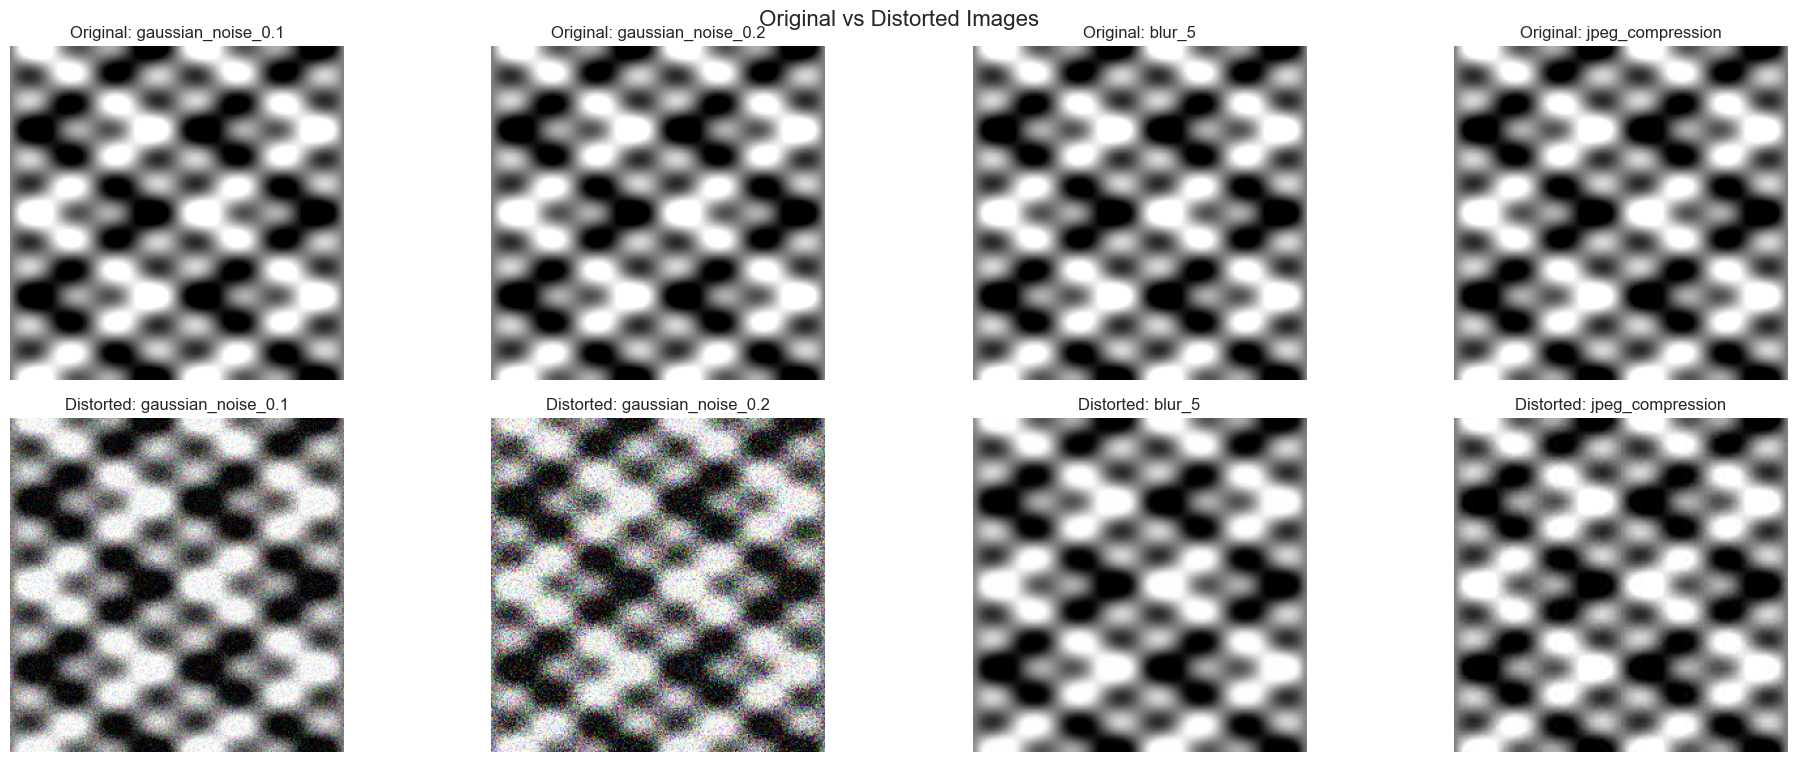

In [5]:
# Visualize test images
fig, axes = plt.subplots(2, len(test_images), figsize=(20, 8))
fig.suptitle('Original vs Distorted Images', fontsize=16, y=0.95)

for i, (name, data) in enumerate(test_images.items()):
    original = data['reference']
    distorted = data['distorted']
    
    # Original image
    axes[0, i].imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    axes[0, i].set_title(f'Original: {name}', fontsize=12)
    axes[0, i].axis('off')
    
    # Distorted image
    axes[1, i].imshow(distorted, cmap='gray' if len(distorted.shape) == 2 else None)
    axes[1, i].set_title(f'Distorted: {name}', fontsize=12)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 🔍 Full-Reference Metrics Evaluation

### Classical Metrics (18th-19th Century Foundations)

Let's start with the fundamental metrics that form the basis of image quality assessment:

In [7]:
# Evaluate classical metrics
print("🎯 CLASSICAL METRICS EVALUATION")
print("=" * 50)

classical_results = []

for name, data in test_images.items():
    original = data['reference']
    distorted = data['distorted']
    
    print(f"\n📷 Image: {name}")
    print("-" * 30)
    
    # Classical metrics
    mse_val = mse(original, distorted)
    mae_val = mae(original, distorted)
    rmse_val = rmse(original, distorted)
    psnr_val = psnr(original, distorted)
    
    results = {
        'Image': name,
        'MSE': mse_val,
        'MAE': mae_val,
        'RMSE': rmse_val,
        'PSNR': psnr_val
    }
    classical_results.append(results)
    
    print(f"MSE:  {mse_val:.6f}")
    print(f"MAE:  {mae_val:.6f}")
    print(f"RMSE: {rmse_val:.6f}")
    print(f"PSNR: {psnr_val:.2f} dB")

# Convert to DataFrame for analysis
classical_df = pd.DataFrame(classical_results)
print("\n📊 Classical Metrics Summary:")
print(classical_df.round(4))

🎯 CLASSICAL METRICS EVALUATION

📷 Image: gaussian_noise_0.1
------------------------------
MSE:  0.008563
MAE:  0.070106
RMSE: 0.092539
PSNR: 20.67 dB

📷 Image: gaussian_noise_0.2
------------------------------
MSE:  0.031119
MAE:  0.133474
RMSE: 0.176405
PSNR: 15.07 dB

📷 Image: blur_5
------------------------------
MSE:  0.000080
MAE:  0.005658
RMSE: 0.008928
PSNR: 40.98 dB

📷 Image: jpeg_compression
------------------------------
MSE:  0.000114
MAE:  0.007862
RMSE: 0.010682
PSNR: 39.43 dB

📊 Classical Metrics Summary:
                Image     MSE     MAE    RMSE     PSNR
0  gaussian_noise_0.1  0.0086  0.0701  0.0925  20.6735
1  gaussian_noise_0.2  0.0311  0.1335  0.1764  15.0698
2              blur_5  0.0001  0.0057  0.0089  40.9844
3    jpeg_compression  0.0001  0.0079  0.0107  39.4269


### Structural Similarity Metrics (Early 2000s)

In [16]:
# Evaluate structural similarity metrics
print("\n🏗️ STRUCTURAL SIMILARITY METRICS")
print("=" * 50)

structural_results = []

for name, data in test_images.items():
    original = data['reference']
    distorted = data['distorted']
    
    print(f"\n📷 Image: {name}")
    print("-" * 30)
    
    # Structural metrics
    uiqi_val = uiqi(original, distorted)
    ssim_val = ssim(original, distorted)
    ms_ssim_val = ms_ssim(original, distorted)
    
    results = {
        'Image': name,
        'UIQI': uiqi_val,
        'SSIM': ssim_val,
        'MS-SSIM': ms_ssim_val
    }
    structural_results.append(results)
    
    print(f"UIQI:    {uiqi_val:.4f}")
    print(f"SSIM:    {ssim_val:.4f}")
    print(f"MS-SSIM: {ms_ssim_val:.4f}")

# Convert to DataFrame
structural_df = pd.DataFrame(structural_results)
print("\n📊 Structural Metrics Summary:")
print(structural_df.round(4))


🏗️ STRUCTURAL SIMILARITY METRICS

📷 Image: gaussian_noise_0.1
------------------------------


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4>, cv::impl::(anonymous namespace)::Set<1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4>, VDcn = cv::impl::(anonymous namespace)::Set<1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


### Advanced Perceptual Metrics (2000s-2010s)

In [ ]:
# Evaluate advanced perceptual metrics
print("\n🧠 ADVANCED PERCEPTUAL METRICS")
print("=" * 50)

advanced_results = []

for name, data in test_images.items():
    original = data['original']
    distorted = data['distorted']
    
    print(f"\n📷 Image: {name}")
    print("-" * 30)
    
    # Advanced metrics
    vif_val = vif(original, distorted)
    mad_val = mad(original, distorted)
    fsim_val = fsim(original, distorted)
    gmsd_val = gmsd(original, distorted)
    
    results = {
        'Image': name,
        'VIF': vif_val,
        'MAD': mad_val,
        'FSIM': fsim_val,
        'GMSD': gmsd_val
    }
    advanced_results.append(results)
    
    print(f"VIF:  {vif_val:.4f}")
    print(f"MAD:  {mad_val:.4f}")
    print(f"FSIM: {fsim_val:.4f}")
    print(f"GMSD: {gmsd_val:.4f}")

# Convert to DataFrame
advanced_df = pd.DataFrame(advanced_results)
print("\n📊 Advanced Metrics Summary:")
print(advanced_df.round(4))

### Deep Learning-Based Metrics (2010s-2020s)

In [ ]:
# Evaluate deep learning-based metrics
print("\n🤖 DEEP LEARNING-BASED METRICS")
print("=" * 50)

try:
    # Initialize LPIPS model
    lpips_model = LPIPS()
    
    dl_results = []
    
    for name, data in test_images.items():
        original = data['original']
        distorted = data['distorted']
        
        print(f"\n📷 Image: {name}")
        print("-" * 30)
        
        # Deep learning metrics
        lpips_val = lpips_model.compute(original, distorted)
        dists_val = dists(original, distorted)
        cross_iqa_val = cross_iqa(original, distorted)
        
        results = {
            'Image': name,
            'LPIPS': lpips_val,
            'DISTS': dists_val,
            'Cross-IQA': cross_iqa_val
        }
        dl_results.append(results)
        
        print(f"LPIPS:     {lpips_val:.4f}")
        print(f"DISTS:     {dists_val:.4f}")
        print(f"Cross-IQA: {cross_iqa_val:.4f}")
    
    # Convert to DataFrame
    dl_df = pd.DataFrame(dl_results)
    print("\n📊 Deep Learning Metrics Summary:")
    print(dl_df.round(4))
    
except Exception as e:
    print(f"⚠️ Deep learning metrics evaluation failed: {e}")
    print("This might be due to missing PyTorch or other dependencies.")
    dl_df = pd.DataFrame()  # Empty DataFrame for later use

## 🔬 No-Reference Metrics Evaluation

Now let's evaluate metrics that don't require a reference image:

In [ ]:
# Evaluate no-reference metrics
print("\n🎯 NO-REFERENCE METRICS EVALUATION")
print("=" * 50)

nr_results = []

for name, data in test_images.items():
    distorted = data['distorted']
    
    print(f"\n📷 Image: {name}")
    print("-" * 30)
    
    try:
        # No-reference metrics
        brisque_val = brisque(distorted)
        niqe_val = niqe(distorted)
        pique_val = pique(distorted)
        blinds_val = blinds_ii(distorted)
        
        results = {
            'Image': name,
            'BRISQUE': brisque_val,
            'NIQE': niqe_val,
            'PIQUE': pique_val,
            'BLINDS-II': blinds_val
        }
        nr_results.append(results)
        
        print(f"BRISQUE:   {brisque_val:.4f}")
        print(f"NIQE:      {niqe_val:.4f}")
        print(f"PIQUE:     {pique_val:.4f}")
        print(f"BLINDS-II: {blinds_val:.4f}")
        
    except Exception as e:
        print(f"⚠️ Error computing NR metrics for {name}: {e}")
        results = {
            'Image': name,
            'BRISQUE': np.nan,
            'NIQE': np.nan,
            'PIQUE': np.nan,
            'BLINDS-II': np.nan
        }
        nr_results.append(results)

# Convert to DataFrame
nr_df = pd.DataFrame(nr_results)
print("\n📊 No-Reference Metrics Summary:")
print(nr_df.round(4))

### Generative Model Quality Metrics

In [ ]:
# Evaluate generative model quality metrics
print("\n🎨 GENERATIVE MODEL QUALITY METRICS")
print("=" * 50)

try:
    # Prepare image batches for IS and FID
    original_batch = []
    distorted_batch = []
    
    for name, data in test_images.items():
        original_batch.append(data['original'])
        distorted_batch.append(data['distorted'])
    
    # Convert to numpy arrays
    original_batch = np.array(original_batch)
    distorted_batch = np.array(distorted_batch)
    
    # Compute Inception Score
    print("\n📊 Computing Inception Score...")
    is_original = inception_score(original_batch)
    is_distorted = inception_score(distorted_batch)
    
    print(f"Inception Score (Original):  {is_original:.4f}")
    print(f"Inception Score (Distorted): {is_distorted:.4f}")
    
    # Compute FID Score
    print("\n📊 Computing FID Score...")
    fid_score = fid(original_batch, distorted_batch)
    print(f"FID Score: {fid_score:.4f}")
    
    # Store results
    generative_results = {
        'Inception Score (Original)': is_original,
        'Inception Score (Distorted)': is_distorted,
        'FID Score': fid_score
    }
    
except Exception as e:
    print(f"⚠️ Generative metrics evaluation failed: {e}")
    print("This might be due to missing dependencies or insufficient data.")
    generative_results = {}

print("\n📊 Generative Metrics Summary:")
for metric, value in generative_results.items():
    print(f"{metric}: {value:.4f}")

## 📈 Comprehensive Results Visualization

In [ ]:
# Create comprehensive visualization of all metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Image Quality Assessment Metrics - Comprehensive Analysis', fontsize=16, y=0.95)

# 1. Classical Metrics Heatmap
if not classical_df.empty:
    classical_data = classical_df.set_index('Image').T
    sns.heatmap(classical_data, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,0])
    axes[0,0].set_title('Classical Metrics (Lower = Better for MSE, MAE, RMSE; Higher = Better for PSNR)')
    axes[0,0].set_ylabel('Metrics')

# 2. Structural Metrics Heatmap
if not structural_df.empty:
    structural_data = structural_df.set_index('Image').T
    sns.heatmap(structural_data, annot=True, fmt='.3f', cmap='plasma', ax=axes[0,1])
    axes[0,1].set_title('Structural Similarity Metrics (Higher = Better)')
    axes[0,1].set_ylabel('Metrics')

# 3. Advanced Metrics Heatmap
if not advanced_df.empty:
    advanced_data = advanced_df.set_index('Image').T
    sns.heatmap(advanced_data, annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1,0])
    axes[1,0].set_title('Advanced Perceptual Metrics (Mixed Interpretation)')
    axes[1,0].set_ylabel('Metrics')
    axes[1,0].set_xlabel('Images')

# 4. No-Reference Metrics Heatmap
if not nr_df.empty and not nr_df.isna().all().all():
    nr_data = nr_df.set_index('Image').T
    sns.heatmap(nr_data, annot=True, fmt='.3f', cmap='magma', ax=axes[1,1])
    axes[1,1].set_title('No-Reference Metrics (Lower = Better Quality)')
    axes[1,1].set_ylabel('Metrics')
    axes[1,1].set_xlabel('Images')
else:
    axes[1,1].text(0.5, 0.5, 'No-Reference Metrics\nNot Available', 
                   ha='center', va='center', transform=axes[1,1].transAxes, fontsize=14)
    axes[1,1].set_title('No-Reference Metrics')

plt.tight_layout()
plt.show()

## 📊 Metrics Correlation Analysis

In [ ]:
# Combine all full-reference metrics for correlation analysis
all_metrics_df = classical_df.copy()

if not structural_df.empty:
    all_metrics_df = all_metrics_df.merge(structural_df, on='Image')

if not advanced_df.empty:
    all_metrics_df = all_metrics_df.merge(advanced_df, on='Image')

if not dl_df.empty:
    all_metrics_df = all_metrics_df.merge(dl_df, on='Image')

print("📊 METRICS CORRELATION ANALYSIS")
print("=" * 50)

if len(all_metrics_df) > 1:
    # Compute correlation matrix (excluding Image column)
    numeric_cols = all_metrics_df.select_dtypes(include=[np.number]).columns
    correlation_matrix = all_metrics_df[numeric_cols].corr()
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='RdBu_r', center=0, square=True, cbar_kws={"shrink": .8})
    plt.title('Image Quality Metrics Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print strong correlations
    print("\n🔗 Strong Correlations (|r| > 0.7):")
    strong_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                metric1 = correlation_matrix.columns[i]
                metric2 = correlation_matrix.columns[j]
                strong_corr.append((metric1, metric2, corr_val))
                print(f"{metric1} ↔ {metric2}: {corr_val:.3f}")
    
    if not strong_corr:
        print("No strong correlations found (|r| > 0.7)")
else:
    print("⚠️ Insufficient data for correlation analysis (need multiple images)")

## 📚 Metrics Interpretation Guide

### Understanding the Results

**Classical Metrics (18th-19th Century Foundations):**
- **MSE/MAE/RMSE**: Lower values indicate better quality (less error)
- **PSNR**: Higher values indicate better quality (typically 20-40 dB range)

**Structural Similarity (Early 2000s):**
- **UIQI/SSIM/MS-SSIM**: Range [0,1], higher values indicate better structural preservation
- Values > 0.9 indicate excellent quality, < 0.5 indicate poor quality

**Advanced Perceptual (2000s-2010s):**
- **VIF**: Higher values indicate better information preservation
- **FSIM**: Range [0,1], higher values indicate better feature similarity
- **MAD/GMSD**: Lower values indicate better quality

**Deep Learning-Based (2010s-2020s):**
- **LPIPS**: Lower values indicate better perceptual similarity
- **DISTS**: Lower values indicate better quality
- **Cross-IQA**: Modern multi-modal assessment

**No-Reference Metrics:**
- **BRISQUE/NIQE/PIQUE**: Lower values indicate better naturalness
- **BLINDS-II**: Blind quality assessment

**Generative Model Metrics:**
- **Inception Score**: Higher values indicate better diversity and quality
- **FID**: Lower values indicate better similarity to real data

## 🛠️ Practical Usage Examples

In [ ]:
# Practical usage examples
print("🛠️ PRACTICAL USAGE EXAMPLES")
print("=" * 50)

# Example 1: Quick quality assessment
print("\n1️⃣ Quick Quality Assessment:")
print("-" * 30)

if test_images:
    sample_name = list(test_images.keys())[0]
    original = test_images[sample_name]['original']
    distorted = test_images[sample_name]['distorted']
    
    # Use the utility function
    quick_results = evaluate_all_metrics(original, distorted)
    print_metrics_summary(quick_results)

# Example 2: Batch processing
print("\n2️⃣ Batch Processing Multiple Images:")
print("-" * 40)

batch_results = []
for name, data in test_images.items():
    metrics = evaluate_all_metrics(data['original'], data['distorted'])
    metrics['Image'] = name
    batch_results.append(metrics)

# Convert to DataFrame for easy analysis
batch_df = pd.DataFrame(batch_results)
print("\n📊 Batch Results Summary:")
print(batch_df[['Image', 'PSNR', 'SSIM', 'MSE']].round(4))

# Example 3: Best/Worst quality identification
if len(batch_df) > 1:
    print("\n3️⃣ Quality Ranking:")
    print("-" * 20)
    
    # Sort by PSNR (higher is better)
    psnr_ranking = batch_df.sort_values('PSNR', ascending=False)
    print("🏆 Best Quality (by PSNR):")
    print(f"   {psnr_ranking.iloc[0]['Image']}: {psnr_ranking.iloc[0]['PSNR']:.2f} dB")
    
    if len(psnr_ranking) > 1:
        print("🔻 Worst Quality (by PSNR):")
        print(f"   {psnr_ranking.iloc[-1]['Image']}: {psnr_ranking.iloc[-1]['PSNR']:.2f} dB")

## 🎯 Recommendations for Different Use Cases

### When to Use Each Metric:

**For General Purpose:**
- Start with **PSNR** and **SSIM** - widely used and well-understood
- Add **MS-SSIM** for multi-scale analysis

**For Perceptual Quality:**
- Use **LPIPS** for deep learning-based perceptual assessment
- Consider **FSIM** for feature-based similarity
- **VIF** for information fidelity

**For No-Reference Assessment:**
- **BRISQUE** for natural image quality
- **NIQE** for naturalness evaluation
- **PIQUE** for distortion-specific assessment

**For Research/Development:**
- **Cross-IQA** for latest multi-modal approaches
- **DISTS** for structure and texture assessment
- **FID** for generative model evaluation

**Performance vs Accuracy Trade-off:**
- **Fast**: MSE, PSNR, MAE
- **Balanced**: SSIM, UIQI
- **Slow but Accurate**: LPIPS, VIF, MS-SSIM

## 📝 Summary and Conclusions

This notebook demonstrates a comprehensive implementation of Image Quality Assessment metrics spanning over two centuries of development:

### Historical Timeline:
- **Classical Era (18th-19th Century)**: MSE, MAE, RMSE foundations
- **Statistical Era (20th Century)**: PSNR development
- **Structural Era (2000s)**: UIQI, SSIM revolution
- **Perceptual Era (2000s-2010s)**: VIF, FSIM, GMSD advances
- **Deep Learning Era (2010s-2020s)**: LPIPS, DISTS innovations
- **Modern Era (2020s)**: Cross-IQA, advanced no-reference methods

### Key Insights:
1. **No single metric is perfect** - different metrics capture different aspects of quality
2. **Context matters** - choose metrics based on your specific application
3. **Human perception is complex** - modern metrics try to align with human visual system
4. **Computational cost varies** - balance between accuracy and speed

### Future Directions:
- Integration of attention mechanisms
- Multi-modal quality assessment
- Real-time quality optimization
- Personalized quality metrics

---

*This implementation provides a solid foundation for image quality research and practical applications. The metrics can be easily extended and customized for specific use cases.*